In [3]:
#import numpy as np
from pickle import load
from votekit.utils import mentions
#from tqdm import tqdm
#import matplotlib.pyplot as plt
#import random
from src.viz import viz_partition
from src.markov import gen_mentions_partition, random_partition, fast_tilted_run, fast_short_burst, calibrate_scores, short_burst, forward_convert, backward_convert
from src.scores import cut_score, relative_size_score, proportional_successive_matrix, cut_score_generator, relative_size_score_generator, first_second_score
from src.cleaning import Portland_clean, clean_and_make_boost, Scotland_clean
from src.clustering import create_graph_louvain_bm, louvain_partition_from_graph
#from functools import partial


Note: to be able to use all crisp methods, you need to install some additional packages:  {'graph_tool'}


Restricted license - for non-production use only - expires 2026-11-23
Restricted license - for non-production use only - expires 2026-11-23
Restricted license - for non-production use only - expires 2026-11-23
Restricted license - for non-production use only - expires 2026-11-23
Restricted license - for non-production use only - expires 2026-11-23
Restricted license - for non-production use only - expires 2026-11-23
Note: to be able to use all crisp methods, you need to install some additional packages:  {'ASLPAw'}


## Data Loading
We pre-cleaned a profile for this notebook to execute fast, but this pickle was generated by functions available in the "src/loading.py" script.

In [4]:
from src.cleaning import clean_and_make_boost

with open('./data/Portland_D4.pkl', 'rb') as file:
    loaded = load(file)
boost = loaded['boost']
profile = loaded['profile']
#profile, boost = clean_and_make_boost(profile)
#profile, boost = clean_and_make_boost(loaded['profile']) 
candidates = list(profile.candidates) #note: we call this the canonical ordering of candidates. It is important for viz + conversion tools.
print(candidates)

['Ben Hufford', 'John Toran', 'Olivia Clark', 'Bob Weinstein', 'Mike DiNapoli', 'Lisa Freeman', 'Lee Odell', 'Chris Henry', 'Sarah Silkie', 'Raquel Coyote', 'Chad Lykins', 'John J Goldsmith', 'L Christopher Regis', 'Eric Zimmerman', 'Eli Arnold', 'Ciatta R Thompson', 'Stanley Penkin', 'Chloe Mason', 'Tony Schwartz', 'Brandon Farley', 'Moses Ross', 'Michael Trimble', 'Joseph (Joe) Alfone', 'Patrick Cashman', 'Andra Vltavin', 'Mitch Green', 'Kevin Goldsmith', 'Bob Callahan', 'Kelly Doyle', 'Tony Morse']


In [5]:
profile

Profile has been cleaned
Profile contains rankings: True
Maximum ranking length: 6
Profile contains scores: False
Candidates: ('Ben Hufford', 'John Toran', 'Olivia Clark', 'Bob Weinstein', 'Mike DiNapoli', 'Lisa Freeman', 'Lee Odell', 'Chris Henry', 'Sarah Silkie', 'Raquel Coyote', 'Chad Lykins', 'John J Goldsmith', 'L Christopher Regis', 'Eric Zimmerman', 'Eli Arnold', 'Ciatta R Thompson', 'Stanley Penkin', 'Chloe Mason', 'Tony Schwartz', 'Brandon Farley', 'Moses Ross', 'Michael Trimble', 'Joseph (Joe) Alfone', 'Patrick Cashman', 'Andra Vltavin', 'Mitch Green', 'Kevin Goldsmith', 'Bob Callahan', 'Kelly Doyle', 'Tony Morse')
Candidates who received votes: ('Andra Vltavin', 'Ben Hufford', 'Chad Lykins', 'Moses Ross', 'Olivia Clark', 'Ciatta R Thompson', 'Chris Henry', 'Sarah Silkie', 'Lisa Freeman', 'Michael Trimble', 'Eric Zimmerman', 'Chloe Mason', 'Eli Arnold', 'Mitch Green', 'Tony Morse', 'John Toran', 'Bob Callahan', 'Kelly Doyle', 'Tony Schwartz', 'L Christopher Regis', 'Mike DiNa

## Visualization

A "partition" is a list of lists of strings, representing a way of partitioning the candidates into slates.

When executing fast chains, we turn this list of lists into a numpy int8 array, where the indices correspond to individual candidates, and the entries correspond to the slate that candidate is sorted into.

The "src/markov.py" has conversion functions to go between these two data types, but most of our API is built to accept input in either format.

The "src/viz.py" has a vizualization function, and "src/markov.py" has some initial partition generators.

List of lists format: [['Stanley Penkin', 'Bob Weinstein', 'John Toran', 'Sarah Silkie', 'Chad Lykins', 'Tony Schwartz', 'Patrick Cashman', 'Kevin Goldsmith', 'Mitch Green', 'Olivia Clark'], ['Eli Arnold', 'Kelly Doyle', 'Bob Callahan', 'Lee Odell', 'Brandon Farley', 'Chloe Mason', 'Michael Trimble', 'Mike DiNapoli', 'Raquel Coyote', 'Tony Morse'], ['Joseph (Joe) Alfone', 'Lisa Freeman', 'Ben Hufford', 'John J Goldsmith', 'Chris Henry', 'L Christopher Regis', 'Andra Vltavin', 'Moses Ross', 'Eric Zimmerman', 'Ciatta R Thompson']]
Numpy int32 array format: [2 0 0 0 1 2 1 2 0 1 0 2 2 2 1 2 0 1 0 1 2 1 2 0 2 0 0 1 1 1]
A random partition we generated:


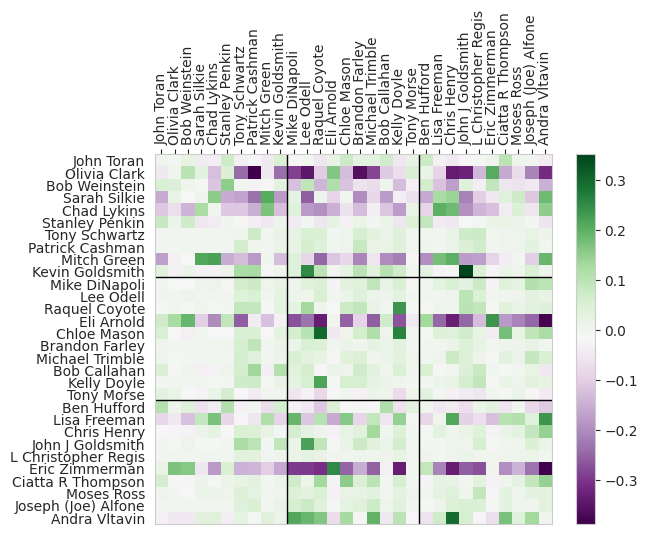

A partition with the candidates sorted by most to least mentions:


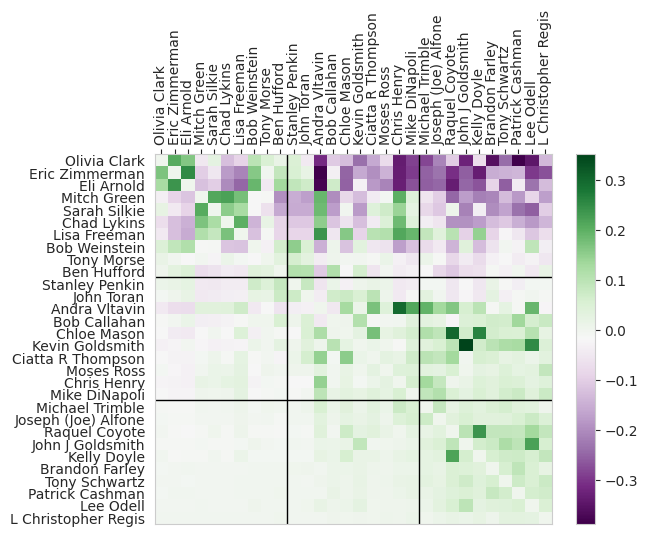

In [6]:
starting_partition = random_partition(candidates, 3)
print(f"List of lists format: {starting_partition}")
converted_partition = forward_convert(starting_partition, profile.candidates)
print(f"Numpy int32 array format: {converted_partition}")
mentions_partition = gen_mentions_partition(profile, candidates, 3)
print("A random partition we generated:")
viz_partition(converted_partition, boost, candidates) #note we passed the converted partition here
print("A partition with the candidates sorted by most to least mentions:")
viz_partition(mentions_partition, boost, candidates)

We can also use these tools to visualize other types of matrices. Below is a "proportional successive matrix"; the (i,j)th entry tells you, out of all the ballots that had candidate i show up somewhere in the ranking, how likely it was for the next ranking to be candidate j.

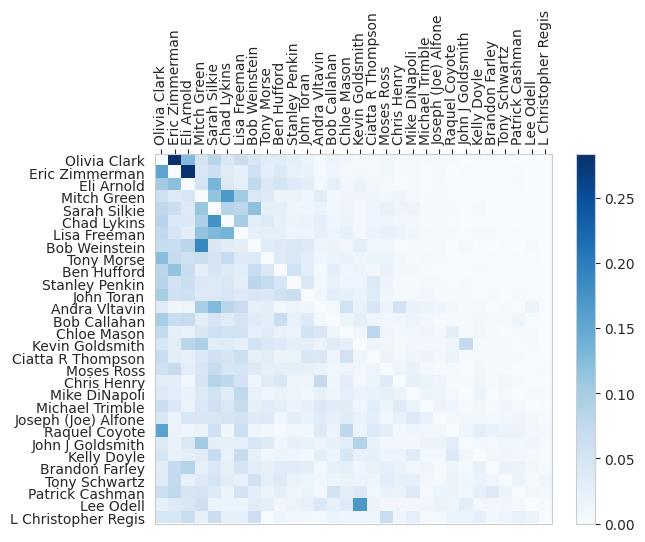

In [7]:
PSM = proportional_successive_matrix(profile)
viz_partition(gen_mentions_partition(profile, candidates, 1), PSM, candidates, cmap='Blues')

## Scores.

The "src/scores.py" contains several scoring functions for partitions, and linear combinations thereof.

As a general rule, these are scores we want to minimize. The cut_score is large when a partition separates candidates who are often adjacent in ballot rankings. The relative_size_score is high when the slates of the partition have unequal total mentions (this is maybe philosophically questionable).

Notice that these scores exist on different scales: the cut_score is normalized to live in $[0,1]$, whereas the the relative_size_score lives in $[k^{-k}, 100^{k-1}]$.

Below, we see that the mentions_partition has a better cut_score than the random partition.

In [6]:
print(cut_score(profile, converted_partition), relative_size_score(profile, converted_partition)) #note we passed the int8 format here and it was fine
print(cut_score(profile, mentions_partition), relative_size_score(profile, mentions_partition))

0.6922639830730238 27.399828027644872
0.48061696734977666 46.326078415441074


When we use them inside a Markov chains, we use score generators rather than score functions.

These are functions that take some input (e.g. the election profile, or the number of blocks in the partition) and return a scoring function tailor-made to remember that information, so it can compute its score fast.

Unlike the basic score functions above, the functions made by score generators only accept the int8 format for partitions.

In [7]:
fast_cut_score = cut_score_generator(profile)
fast_relative_size_score = relative_size_score_generator(profile, k=3)
print(fast_cut_score(converted_partition), fast_relative_size_score(converted_partition))
#note the below should execute pretty fast:
for _ in range(1000):
    fast_cut_score(converted_partition)
    fast_relative_size_score(converted_partition)

0.6922639830730241 27.399828027644865


## Chains.

The "src/markov.py" contains a proposal to get from one partition to the other, as well as a tilted run and a short burst chain, which can be run to optimize any score you pass to it.

The process to setup a chain is pretty straightforward:
1) Generate a fast score function for the chain to optimize;
2) Pass it to the chain along with a starting partition.

By default, the chain only returns the best proposal it found during the chain, but there are options to tweak the output format.

In [8]:
def my_awesome_score(partition):
    return 100*fast_cut_score(partition) + fast_relative_size_score(partition)
best = fast_tilted_run(converted_partition, my_awesome_score, iterations=1000, beta=3)

Combined score of random partition: 96.62622633494726
Combined score of tilted run partition: 83.96249375592802


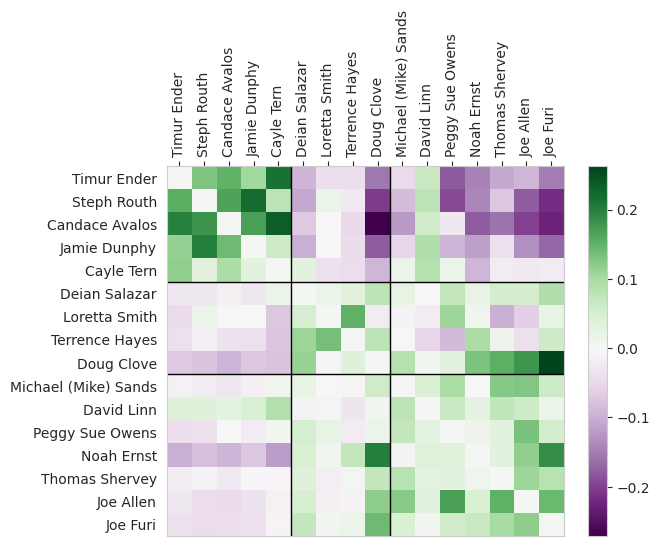

In [9]:
print(f"Combined score of random partition: {my_awesome_score(forward_convert(starting_partition, candidates))}")
print(f"Combined score of tilted run partition: {my_awesome_score(best)}")
viz_partition(best, boost, candidates)

This looks decent, but you might begin to suspect that we would be better off using k=2 slates for this election, rather than 3. Let's try running another tilted run to do this.

Combined score of tilted run partition: 7.033043602529393
Combined score of random partition: 8.248336797832623


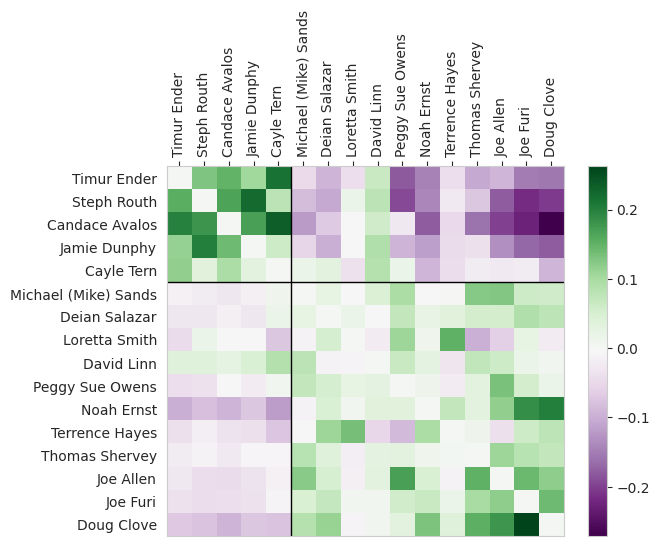

In [10]:
converted_partition = forward_convert(random_partition(candidates, 2), profile.candidates)
fast_relative_size_score2k = relative_size_score_generator(profile, k=2)
def my_awesome_score2k(partition):
    return 8*fast_cut_score(partition) + fast_relative_size_score2k(partition)
best = fast_tilted_run(converted_partition, my_awesome_score2k, iterations=1000, beta = 10)
print(f"Combined score of tilted run partition: {my_awesome_score2k(best)}")
print(f"Combined score of random partition: {my_awesome_score2k(converted_partition)}")
viz_partition(best, boost, candidates)

You may notice that in the above, I manually tweaked the weight on each partition, because cut_score tends to be larger for partitions with more slates (because more candidates get split up). Not only this, but the tilted_run function has a beta parameter which tells it how often to accept worst proposals, which we need to tweak to match new scores. This is a pain to do manually.

Instead, we have a callibrator function that can do this for us! What this does is take a short random walk (1000 steps), look at the range of each score function you pass to it, and re-weight them so they have the same median.

This calibration function returns a scoring function which is weighed to have a median of 100; and the default beta parameter in tilted_run is picked so that a score that is worst by 10 is accepted 1/2 of the time.

In [11]:
super_awesome_score = calibrate_scores([fast_cut_score, fast_relative_size_score2k], converted_partition, print_weights=True)
print(super_awesome_score(converted_partition)) #the "average" partition should score around 100

Weights for score functions (to achieve equal median scores):
Score function 0: 97.68122927712778
Score function 1: 12.363406293564974
101.304025427465


Let's test this new fancy scoring function on a short burst run:

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:00<00:00, 269.05it/s]


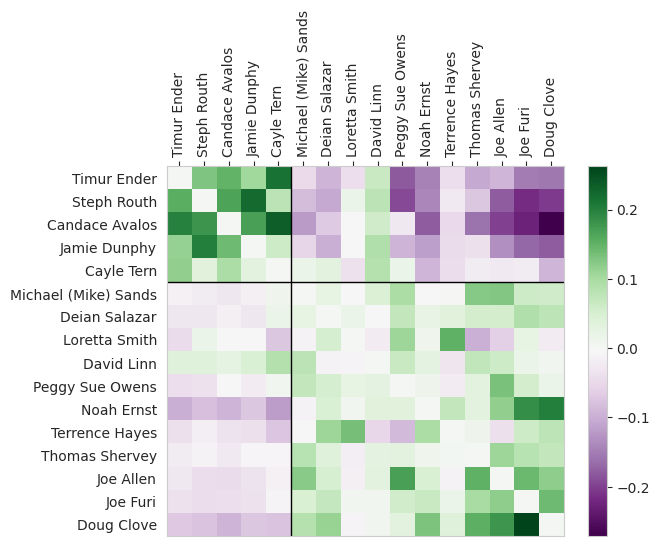

In [12]:
best_burst = fast_short_burst(converted_partition, super_awesome_score)
viz_partition(best_burst, boost, candidates)

In [13]:
cut_score(profile, best_burst)

np.float64(0.39847178712682524)

# Louvain Method for Clustering

Now, we will try a different approach: Louvain method for clustering! Louvain is a greedy algorithm that maximizes modularity (Newman). First, we need to convert our boost matrix intro a graph! The way we are doing this is converting each candidate into a noode and averaging the boost between two candidates. However, due to constraints within the algorithm, if the average sum is negative, then we set that edge to zero.

We provide two methods: create_graph_louvain_bm which converts a boost matrix into a graph, and louvain_partition_from_graph which outputs the best partition found by Louvain and its modularity score.

Notice that Louvain is not deterministic, and so different runs can give different partitions...

In [83]:
# generating graph from the clean boost matrix
G = create_graph_louvain_bm(boost)
partition_louv, modularity_score = louvain_partition_from_graph(G, profile, 1, True)
partition_louv

[['Bob Callahan',
  'Chloe Mason',
  'Kevin Goldsmith',
  'Ciatta R Thompson',
  'Joseph (Joe) Alfone',
  'Raquel Coyote',
  'John J Goldsmith',
  'Kelly Doyle',
  'Brandon Farley',
  'Tony Schwartz',
  'Patrick Cashman',
  'Lee Odell',
  'L Christopher Regis'],
 ['Mitch Green',
  'Sarah Silkie',
  'Chad Lykins',
  'Lisa Freeman',
  'Andra Vltavin',
  'Moses Ross',
  'Chris Henry',
  'Mike DiNapoli',
  'Michael Trimble'],
 ['Olivia Clark',
  'Eric Zimmerman',
  'Eli Arnold',
  'Bob Weinstein',
  'Tony Morse',
  'Ben Hufford',
  'Stanley Penkin',
  'John Toran']]

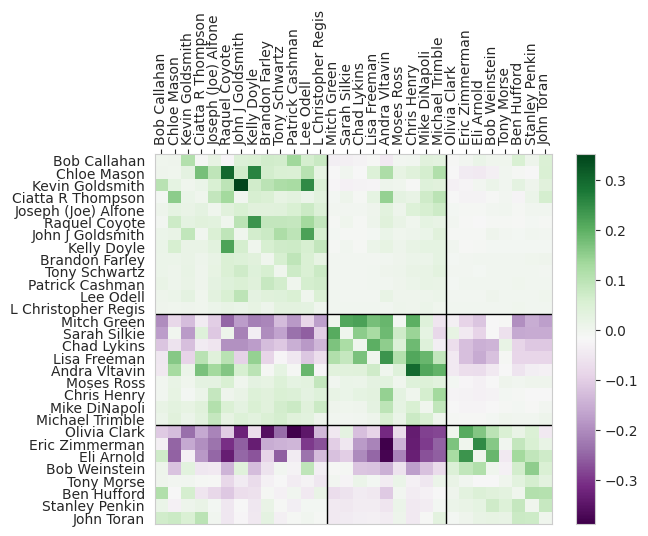

np.float64(0.3655657272712729)

In [84]:
viz_partition(partition_louv, boost, candidates)
modularity_score

In [85]:
print(score1(forward_convert(partition_louv, candidates)))
print(score1(score1result))

-0.4036684470626643
-0.3949520108972568


we can also visualize proportional successive mentions on this new partition

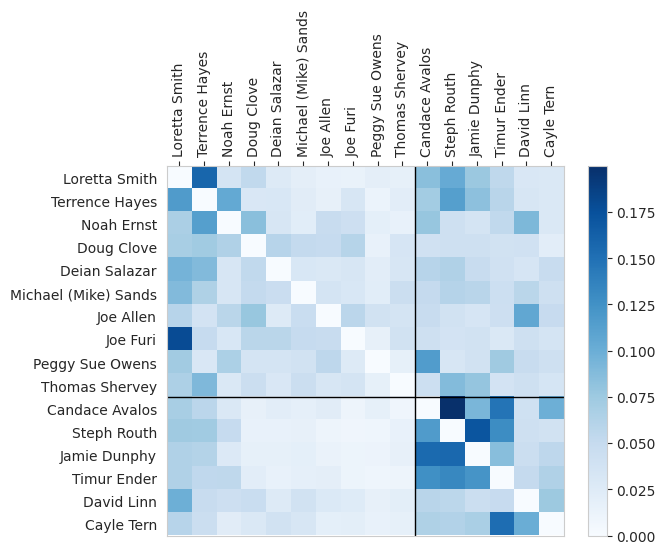

In [17]:
viz_partition(partition_louv, PSM, candidates, cmap='Blues')

In [1]:
import numpy as np

#make a 10x10 matrix with 0s everywhere except 1s on the off-diagonal
#eg [[0,1,0],[1,0,1],[0,1,0]] for 3x3
M = np.zeros((10,10), dtype=np.int32)
for i in range(9):
    M[i, i+1] = 1
    M[i+1, i] = 1
M[4,5] = -1 
M[5,4] = -1
print(M)

[[ 0  1  0  0  0  0  0  0  0  0]
 [ 1  0  1  0  0  0  0  0  0  0]
 [ 0  1  0  1  0  0  0  0  0  0]
 [ 0  0  1  0  1  0  0  0  0  0]
 [ 0  0  0  1  0 -1  0  0  0  0]
 [ 0  0  0  0 -1  0  1  0  0  0]
 [ 0  0  0  0  0  1  0  1  0  0]
 [ 0  0  0  0  0  0  1  0  1  0]
 [ 0  0  0  0  0  0  0  1  0  1]
 [ 0  0  0  0  0  0  0  0  1  0]]


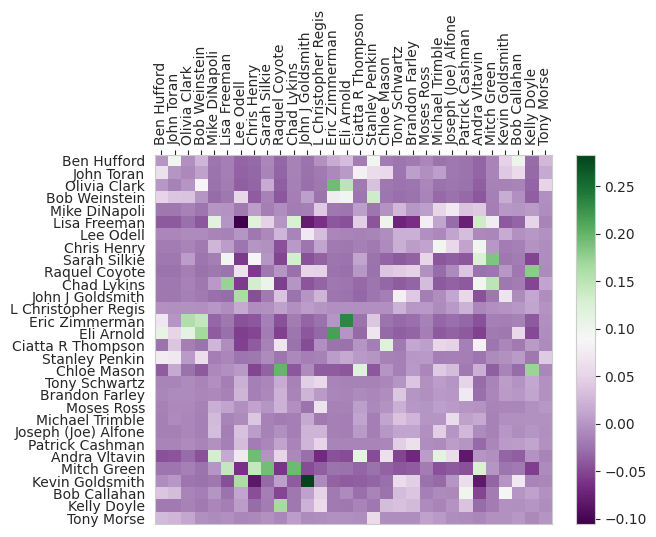

In [23]:
from src.scores import split_matrix, modularity_from_B, make_modularity_matrix
from src.viz import show_matrix
from src.markov import fast_short_burst, fast_proposal_generator

A, B = split_matrix(boost) #replace with M to test the small matrix above
A1 = make_modularity_matrix(A)
B1 = make_modularity_matrix(-B)

viz_partition(backward_convert(np.zeros(30,dtype=np.int32), candidates), A1, candidates)

In [24]:
print(A.sum(), B.sum())

25.32343646490036 -28.646082667503414


In [25]:
modularity_from_B(A1, 25.3, np.array([i<15 for i in range(30)], dtype=np.int32), pm ='pos')

np.float64(0.028626189426564037)

In [26]:
def score1(partition8):
    return (-1)* modularity_from_B(A1, 25.32, partition8, pm='pos')

def score2(partition8):
    return (-1) * modularity_from_B(B1, 28.64, partition8, pm='neg')

def score3(partition8):
    return (-1) * modularity_from_B(A1, 25.32, partition8, mod_type='reverse', pm='pos')

def score4(partition8):
    return (-1) * modularity_from_B(B1, 28.64, partition8, mod_type='reverse', pm='neg')

def score12(partition8):
    return score1(partition8) + score2(partition8)

def score34(partition8):
    return score3(partition8) + score4(partition8)

#proposal = fast_proposal_generator(np.array([i<15 for i in range(30)], dtype=np.int32))

In [82]:
score1(score1result)

np.float64(-0.3949520108972568)

  0%|          | 0/20000 [00:00<?, ?it/s]

100%|██████████| 20000/20000 [00:24<00:00, 818.93it/s]


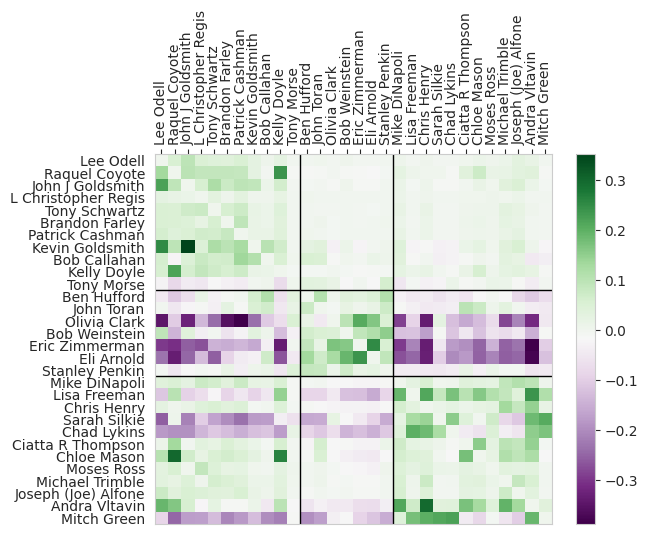

In [27]:
score1result = fast_short_burst(2*np.array([i<15 for i in range(30)], dtype=np.int32), score1, burst_size=5,num_bursts=20000)
viz_partition(score1result, boost, candidates)

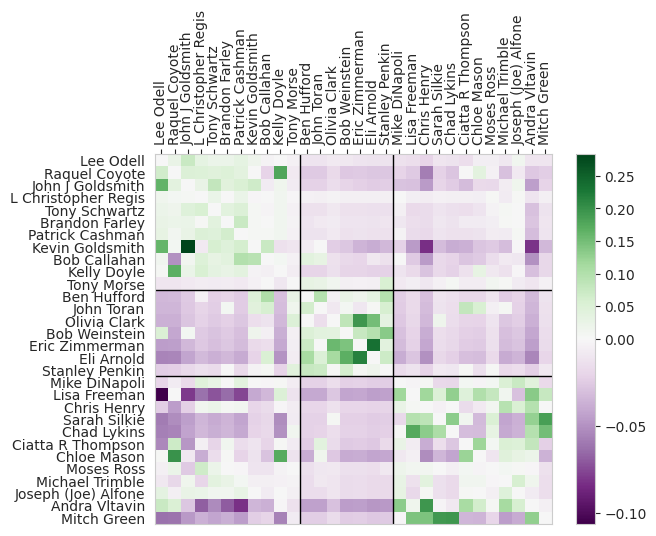

In [33]:
viz_partition(score1result, A1, candidates, centered=True)

  0%|          | 0/100000 [00:00<?, ?it/s]

100%|██████████| 100000/100000 [02:24<00:00, 693.98it/s]


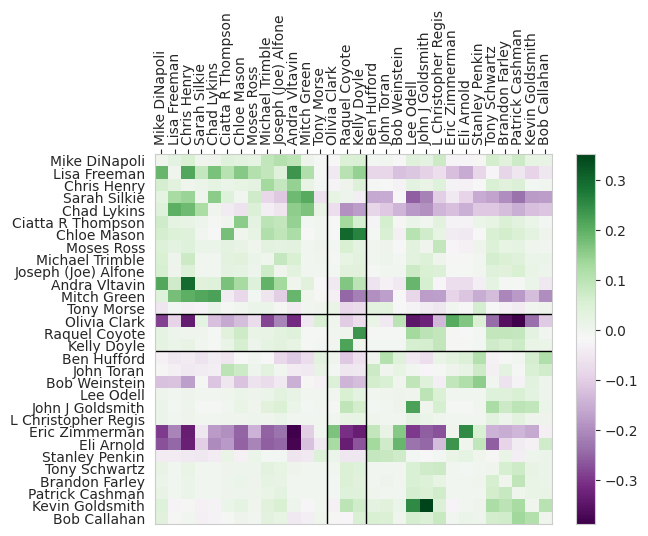

In [28]:
score2result=fast_short_burst(2*np.array([i<15 for i in range(30)], dtype=np.int32), score2, burst_size=5,num_bursts=100000)
viz_partition(score2result, boost, candidates)

In [81]:
score2(score2result)

np.float64(-0.24276371975744868)

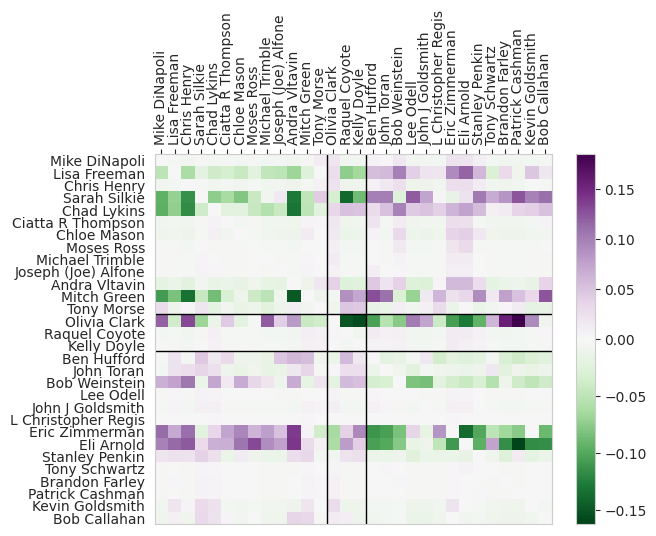

In [41]:
viz_partition(score2result, B1, candidates, cmap = "PRGn_r",centered=True)

100%|██████████| 10000/10000 [00:31<00:00, 321.39it/s]


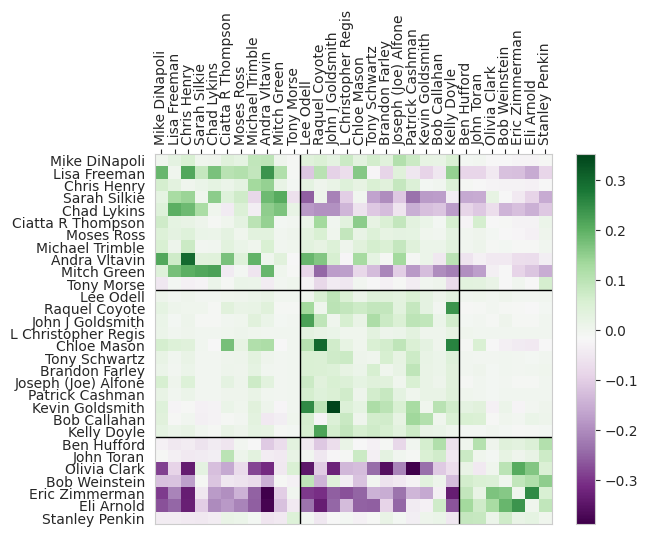

In [29]:
score3result = fast_short_burst(2*np.array([i<15 for i in range(30)], dtype=np.int8), score3, burst_size=10,num_bursts=10000)
viz_partition(backward_convert(score3result, candidates), boost, candidates)

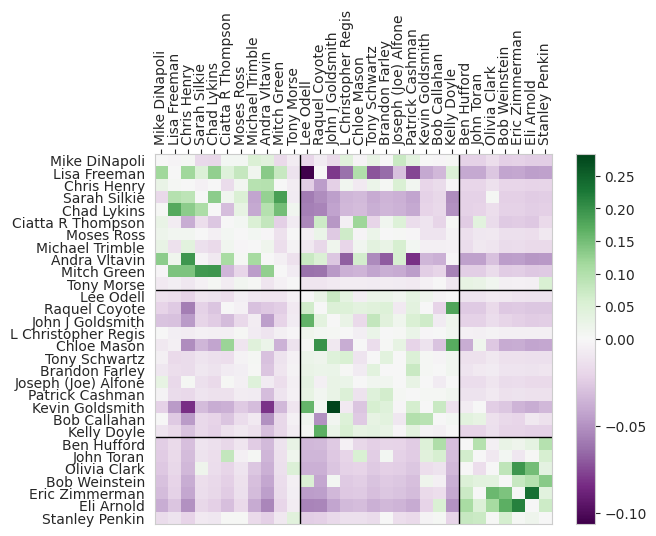

In [35]:
viz_partition(score3result, A1,candidates, centered=True)

100%|██████████| 25000/25000 [00:36<00:00, 685.75it/s]


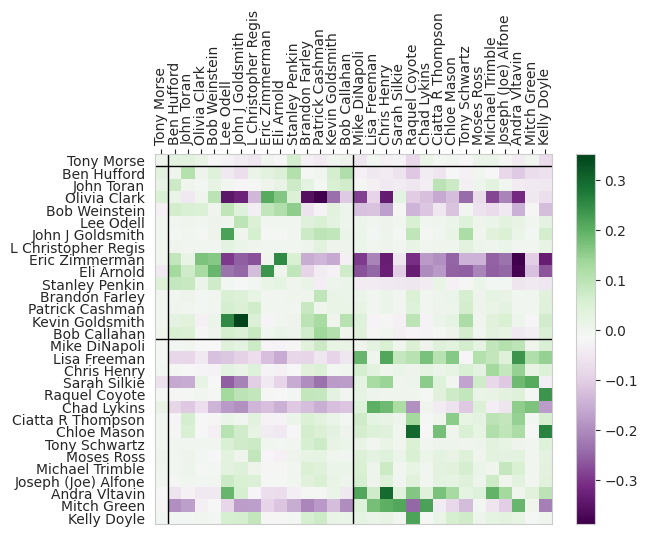

In [39]:
score4result = fast_short_burst(2*np.array([i<15 for i in range(30)], dtype=np.int8), score4, burst_size=5,num_bursts=25000)
viz_partition(score4result, boost, candidates)

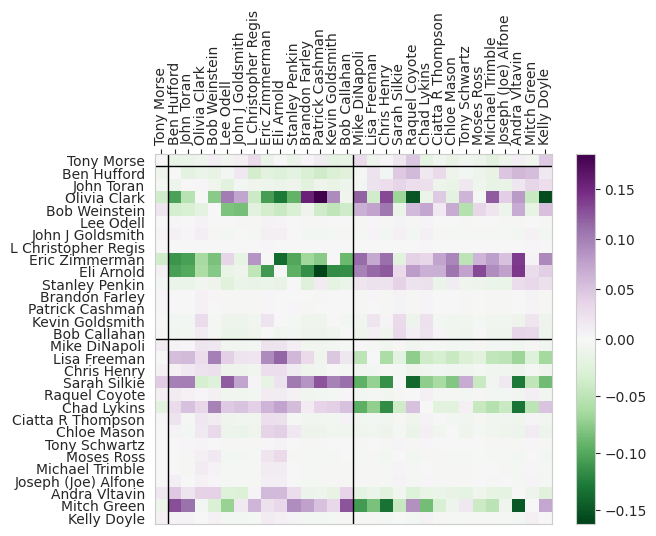

In [42]:
viz_partition(score4result, B1, candidates, cmap = "PRGn_r",centered=True)

  0%|          | 0/20000 [00:00<?, ?it/s]

100%|██████████| 20000/20000 [00:56<00:00, 353.80it/s]


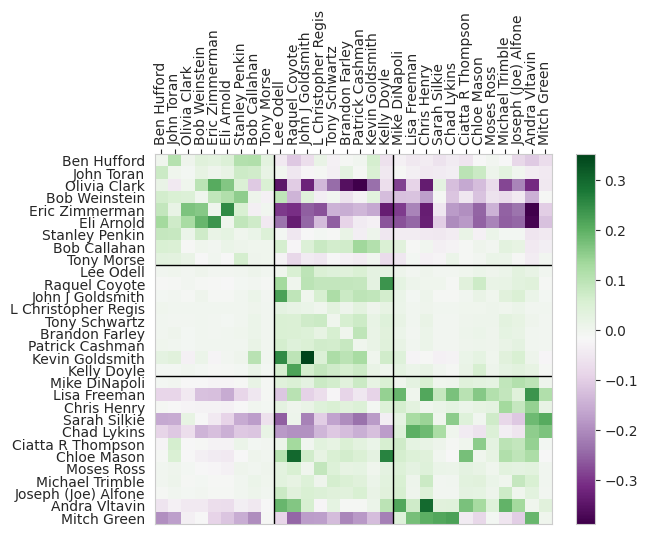

In [43]:
score12result=fast_short_burst(2*np.array([i<15 for i in range(30)], dtype=np.int32), score12, burst_size=5,num_bursts=20000)
viz_partition(score12result, boost, candidates)

100%|██████████| 20000/20000 [01:02<00:00, 319.73it/s]


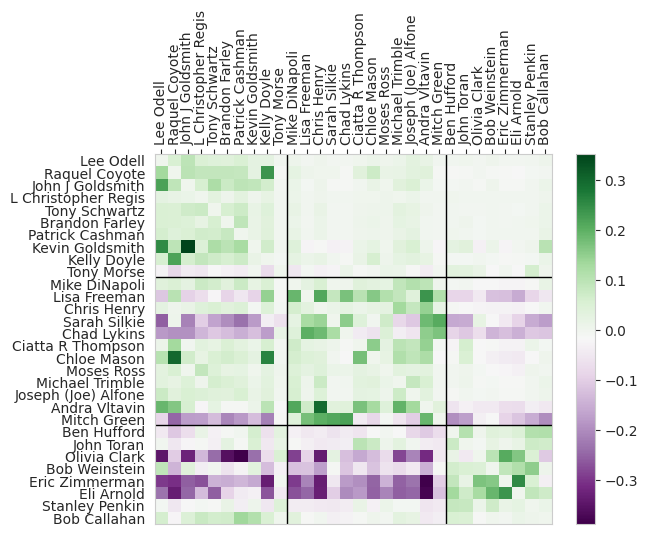

In [14]:
score34result=fast_short_burst(2*np.array([i<15 for i in range(30)], dtype=np.int32), score34, burst_size=5,num_bursts=20000)
viz_partition(score34result, boost, candidates)

In [52]:
score12(np.array([0,0,0,0,0,0,0,0,0,0], dtype=np.int32))

np.float64(-0.0)

In [37]:
score2(score2result)

np.float64(-0.0625)

In [9]:
from src.clustering import louvain_directed, louvain_directed_hybrid

louv = louvain_directed(boost, 'neg')
louv_hybrid = louvain_directed_hybrid(boost)

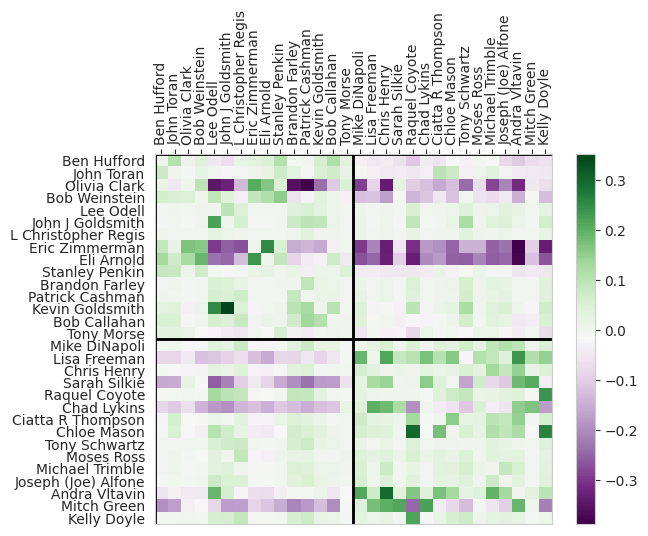

In [10]:
viz_partition(backward_convert(louv,candidates), boost, candidates)

In [7]:
haters = np.array(range(7), dtype=np.int32)
lovers = np.array(range(8,11), dtype=np.int32)

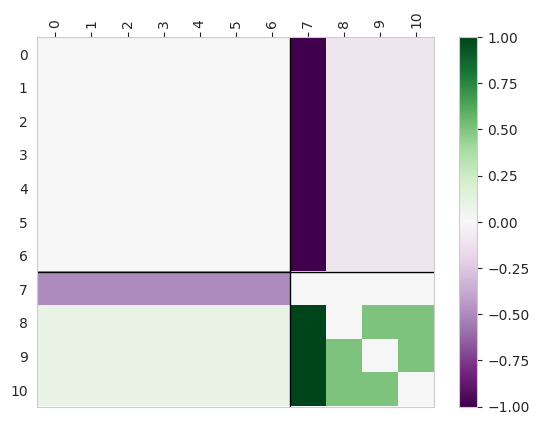

In [54]:
example_matrix = np.zeros((11,11), dtype=np.float64)
for i in haters:
    example_matrix[i, 7] = -1
for i in lovers:
    example_matrix[i, 7] = 1
for i in lovers:
    for j in haters:
        example_matrix[i, j] = 0.1
    for j in lovers:
        if i != j:
            example_matrix[i, j] = 0.5
for i in haters:
    for j in lovers:
        example_matrix[i, j] = -0.1
for i in haters:
    example_matrix[7, i] = -.5
viz_partition(np.array([0,0,0,0,0,0,0,1,1,1,1], dtype=np.int32), example_matrix, [f"{i}" for i in range(11)], centered=True)

In [75]:
AA, BB = split_matrix(example_matrix)
AA1, BB1 = make_modularity_matrix(AA), make_modularity_matrix(-BB)

def example_bad_score(partition8):
    return (-1)*modularity_from_B(AA1, 5, partition8, pm='pos')

def example_good_score(partition8):
    return (-1)*modularity_from_B(BB1, 7, partition8, pm='neg')

hopefullybad= fast_short_burst(np.array([1,1,1,1,1,1,1,1,1,1,1], dtype=np.int32), example_bad_score, burst_size=5,num_bursts=10000)
#hopefullygood= fast_short_burst(np.array([1,1,1,1,1,1,1,1,1,1,1], dtype=np.int32), example_good_score, burst_size=5,num_bursts=10000)

  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [00:02<00:00, 4066.44it/s]


In [76]:
AA1

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
  

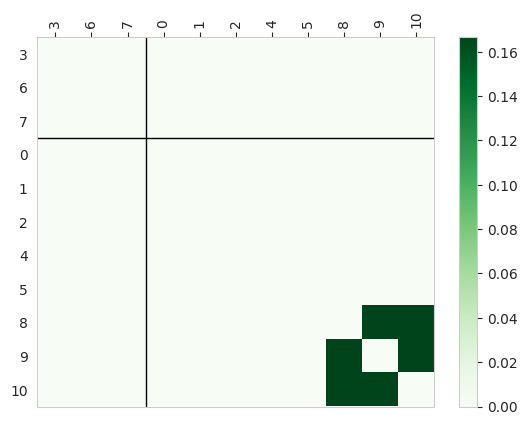

In [74]:
#clean entries from AA1 if they are less than 10**(-15)
AA1[np.abs(AA1) < 10**(-15)] = 0

viz_partition(hopefullybad, AA1, [f"{i}" for i in range(11)],cmap = "Greens")

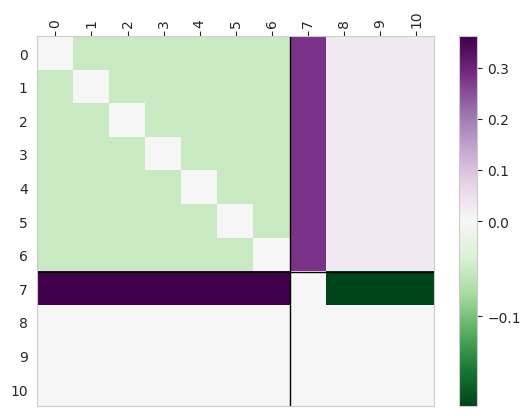

In [62]:
viz_partition(hopefullygood, BB1, [f"{i}" for i in range(11)], cmap= "PRGn_r", centered=True)

In [51]:
-BB

array([[-0., -0., -0., -0., -0., -0., -0.,  1., -0., -0., -0.],
       [-0., -0., -0., -0., -0., -0., -0.,  1., -0., -0., -0.],
       [-0., -0., -0., -0., -0., -0., -0.,  1., -0., -0., -0.],
       [-0., -0., -0., -0., -0., -0., -0.,  1., -0., -0., -0.],
       [-0., -0., -0., -0., -0., -0., -0.,  1., -0., -0., -0.],
       [-0., -0., -0., -0., -0., -0., -0.,  1., -0., -0., -0.],
       [-0., -0., -0., -0., -0., -0., -0.,  1., -0., -0., -0.],
       [-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.],
       [-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.],
       [-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.],
       [-0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.]])

In [44]:
# Redefine groups
haters = list(range(0, 7))        # nodes 0 through 6
lovers = list(range(8, 11))       # nodes 8, 9, 10

# Initialize matrix
example_matrix = np.zeros((11, 11), dtype=np.float64)

for i in haters:
    example_matrix[i, 7] = -1
for i in lovers:
    example_matrix[i, 7] = 1
for i in lovers:
    for j in haters:
        example_matrix[i, j] = 0.1
    for j in lovers:
        if i != j:
            example_matrix[i, j] = 0.5
for i in haters:
    for j in lovers:
        example_matrix[i, j] = -0.1
for i in haters:
    example_matrix[7, i] = -0.5


In [46]:
import networkx as nx

G = nx.DiGraph()

# Positions: lovers on left (-1), node 7 center (0), haters on right (1)
pos = {
    lovers[0]: (-1, -1),
    lovers[1]: (-1,  0),
    lovers[2]: (-1,  1),
    7:         ( 0,  0),
}

# evenly space haters vertically around x=1
hater_y = np.linspace(-1.5, 1.5, len(haters))
for i, h in enumerate(haters):
    pos[h] = (1, hater_y[i])

# add nodes with positions
for node in range(11):
    if node not in pos:
        pos[node] = (0, 0)  # fallback position for unused or middle nodes
    G.add_node(node, pos=pos[node])

# add directed edges
for i in range(11):
    for j in range(11):
        weight = example_matrix[i, j]
        if weight != 0:
            G.add_edge(i, j, weight=weight)


ValueError: Unable to determine Axes to steal space for Colorbar. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.

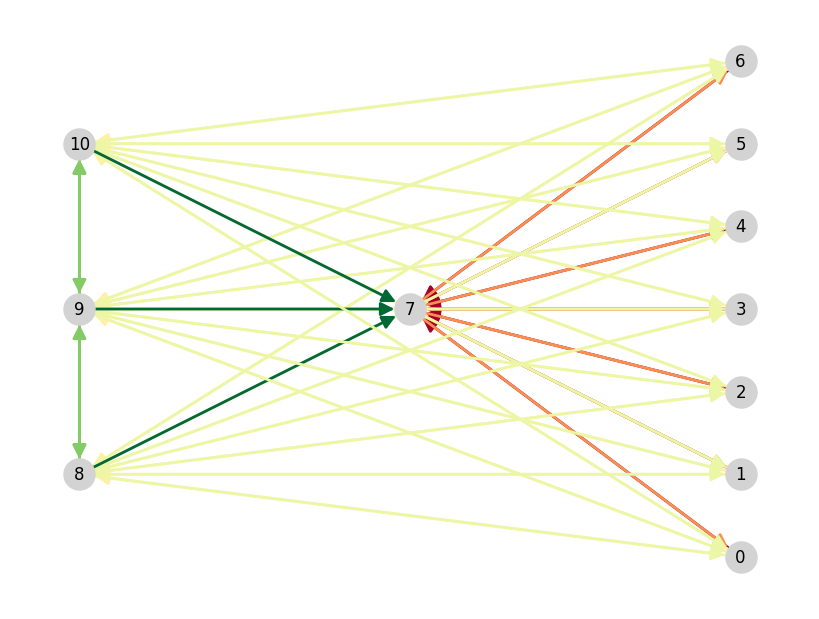

In [53]:
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import matplotlib.cm as cm

def plot_weighted_digraph(G):
    pos = nx.get_node_attributes(G, 'pos')
    weights = np.array([G[u][v]['weight'] for u, v in G.edges])
    
    # Colormap: red for negative, green for positive, centered at 0
    norm = mcolors.TwoSlopeNorm(vmin=weights.min(), vcenter=0, vmax=weights.max())
    cmap = cm.get_cmap('RdYlGn')
    edge_colors = [cmap(norm(G[u][v]['weight'])) for u, v in G.edges]

    plt.figure(figsize=(8, 6))
    nx.draw(
        G, pos,
        with_labels=True,
        node_color='lightgray',
        edge_color=edge_colors,
        node_size=500,
        arrows=True,
        arrowsize=20,
        width=2
    )
    sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
    sm.set_array([])
    plt.colorbar(sm, label="Edge weight")
    plt.axis('equal')
    plt.title("Directed Graph from example_matrix")
    plt.show()

plot_weighted_digraph(G)


plot_directed_digraph(G)


In [68]:
def plot_weighted_digraph(G, lovers, haters):
    pos = nx.get_node_attributes(G, 'pos')
    weights = np.array([G[u][v]['weight'] for u, v in G.edges])

    # Colormap for edges: red for negative, green for positive
    norm = mcolors.TwoSlopeNorm(vmin=weights.min(), vcenter=0, vmax=weights.max())
    cmap = cm.get_cmap('RdYlGn')
    edge_colors = [cmap(norm(G[u][v]['weight'])) for u, v in G.edges]

    # Assign node colors based on group
    node_colors = []
    for node in G.nodes:
        if node in haters:
            node_colors.append('purple')
        else:
            node_colors.append('green')

    plt.figure(figsize=(8, 6))
    nx.draw(
        G, pos,
        with_labels=True,
        node_color=node_colors,
        edge_color=edge_colors,
        node_size=500,
        arrows=True,
        arrowsize=20,
        width=2
    )

    sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
    sm.set_array([])
    plt.colorbar(sm, label="Edge weight")
    plt.axis('equal')
    plt.title("Directed Graph with Haters vs Lovers Coloring")
    plt.show()


ValueError: Unable to determine Axes to steal space for Colorbar. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.

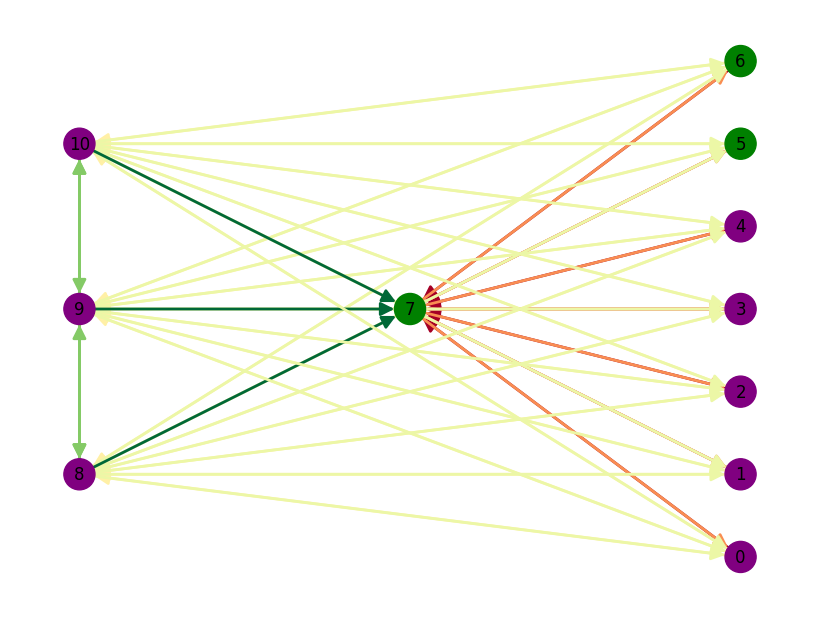

In [70]:
plot_weighted_digraph(G, [5,6,7], [i for i in range(11) if i not in [5,6,7]])

100%|██████████| 20000/20000 [01:20<00:00, 246.96it/s]


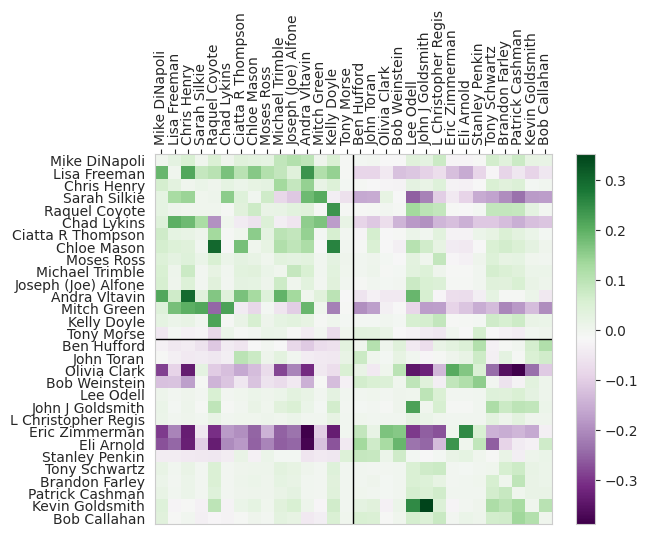

In [78]:
#exponentiate eery entry of the boost matrix
exp = np.exp(boost)
mod = make_modularity_matrix(exp)
exp_best = fast_short_burst(2*np.array([i<15 for i in range(30)], dtype=np.int32), score12, burst_size=5,num_bursts=20000)
viz_partition(exp_best, boost, candidates)

100%|██████████| 20000/20000 [01:15<00:00, 265.25it/s]


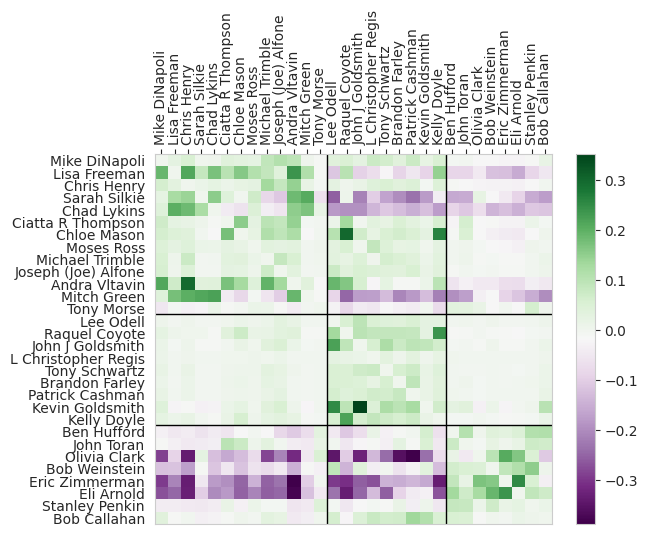

In [79]:
exp_best2 = fast_short_burst(2*np.array([i<15 for i in range(30)], dtype=np.int32), score12, burst_size=5,num_bursts=20000)
viz_partition(exp_best2, boost, candidates)